In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:234: SyntaxWarning: invalid escape sequence '\p'
<>:237: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\p'
<>:234: SyntaxWarning: invalid escape sequence '\p'
<>:237: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\p'
<>:239: SyntaxWarning: invalid escape sequence '\c'
<>:242: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19352\2410850710.py:234: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19352\2410850710.py:237: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_19352\2410850710.py:239: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10

In [118]:
t0 = DData(8.252,0.001,E=-6)
TU = DData(24,1,E=3)

In [119]:
data = pd.read_csv("data.csv")
data["T0"] = data["T0"].apply(lambda x: DData(x, 0.01))
data["U"] = data["U"].apply(lambda x: DData(x, 1.2, E=-6))
data["t"] = data["t"].apply(lambda x: DData(x, 0.001,E=-6))
data["T"] = data["T0"] + data["U"]*TU
DData.changeEInSerias(data["T"],E=0)
data["t^2-t_0^2"] = data["t"]**2-t0**2
data["1/(t^2-t_0^2)"] = 1/data["t^2-t_0^2"]
data

,T0,U,t,T,t^2-t_0^2,1/(t^2-t_0^2)
0,$14.070 \pm 0.010$,$-7.0 \pm 1.2$,$10.6550 \pm 0.0010$,$13.902 \pm 0.031$,$45.434 \pm 0.027$,$0.022010 \pm 0.000013$
1,$16.030 \pm 0.010$,$-12.3 \pm 1.2$,$9.9450 \pm 0.0010$,$15.735 \pm 0.033$,$30.808 \pm 0.026$,$0.032460 \pm 0.000027$
2,$18.010 \pm 0.010$,$-14.2 \pm 1.2$,$9.7490 \pm 0.0010$,$17.669 \pm 0.034$,$26.947 \pm 0.026$,$0.037109 \pm 0.000035$
3,$20.010 \pm 0.010$,$-19.4 \pm 1.2$,$9.4520 \pm 0.0010$,$19.544 \pm 0.036$,$21.245 \pm 0.025$,$0.047070 \pm 0.000056$
4,$22.010 \pm 0.010$,$-18.9 \pm 1.2$,$9.0590 \pm 0.0010$,$21.556 \pm 0.036$,$13.970 \pm 0.025$,$0.07158 \pm 0.00013$
5,$24.020 \pm 0.010$,$-19.6 \pm 1.2$,$8.7510 \pm 0.0010$,$23.550 \pm 0.036$,$8.484 \pm 0.024$,$0.11786 \pm 0.00033$
6,$26.000 \pm 0.010$,$-19.7 \pm 1.2$,$8.6100 \pm 0.0010$,$25.527 \pm 0.036$,$6.037 \pm 0.024$,$0.16566 \pm 0.00065$
7,$27.990 \pm 0.010$,$-19.8 \pm 1.2$,$8.5350 \pm 0.0010$,$27.515 \pm 0.036$,$4.751 \pm 0.024$,$0.2105 \pm 0.0011$
8,$31.000 \pm 0.010$,$-20.9 \pm 1.2$,$8.4690 \pm 0.0010$,$30.498 \pm 0.037$,$3.628 \pm 0.024$,$0.2756 \pm 0.0018$
9,$34.000 \pm 0.010$,$-19.0 \pm 1.2$,$8.4270 \pm 0.0010$,$33.544 \pm 0.036$,$2.919 \pm 0.024$,$0.3426 \pm 0.0028$


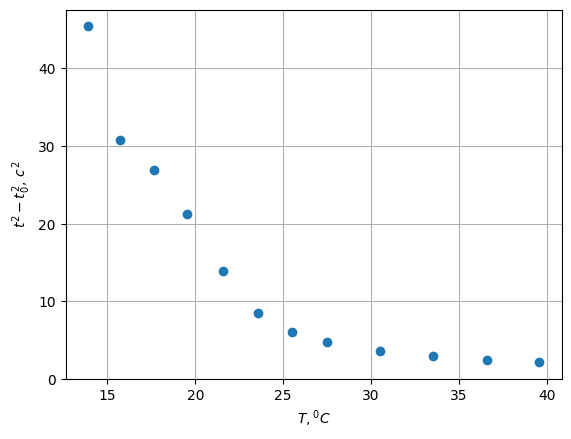

In [120]:
plt.xlabel("$T,^0С$")
plt.ylabel("$t^2-t_0^2$, $c^2$")
plt.grid(True)
data_srez = data[data["T"]<21]
data_srez = data_srez[data_srez["T"]>15]
data_srez.index = range(len(data_srez))
data_srez_2 = data[(data["T"]>20)*(data["T"]<25)]
data_srez_2.index = range(len(data_srez_2))
plt.plot(get_values(data["T"]), get_values(data["t^2-t_0^2"]),"o")
#linearcalc(data_srez["T"], data_srez["t^2-t_0^2"], xmax=22)
#linearcalc(data_srez_2["T"], data_srez_2["t^2-t_0^2"], xmin=19)
plt.savefig("hi.png",dpi=300)

[16.94584 41.59576]
k, b = $0.02202 \pm 0.00023$ $-0.3985 \pm 0.0071$
[12.2 21.8]
k, b = $0.00423 \pm 0.00045$ $-0.0360 \pm 0.0075$
$18.10 \pm 0.37$ $20.38 \pm 0.82$


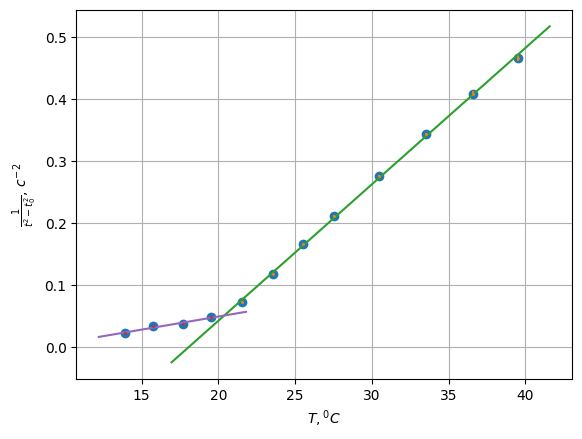

In [121]:
plt.xlabel("$T,^0С$")
plt.ylabel("$\\frac{1}{t^2-t_0^2}$, $c^{-2}$")
plt.plot(get_values(data["T"]), get_values(data["1/(t^2-t_0^2)"]),"o")
data_srez = data[data["T"]>21]
data_srez_2 = data[data["T"]<21]
data_srez.index = range(len(data_srez))
data_srez_2.index = range(len(data_srez_2))
k,b = linearcalc_error(data_srez["T"],1/data_srez["t^2-t_0^2"],xmin=19)
k_2,b_2 = linearcalc_error(data_srez_2["T"],1/data_srez_2["t^2-t_0^2"],xmin=13,xmax=21)
data_srez
theta = -b/k
theta.E = 0
theta_2 = (b_2-b)/(k-k_2)
print(theta,theta_2)

plt.savefig("1hi.png",dpi=300)

In [123]:
data_out = pd.DataFrame()
data_out["$T_0$,$^0С$"] = data["T0"]
data_out["U, мкВ"] = data["U"]
data_out["$\\tau$, мкс"] = data["t"]
data_out["T,$^0С$"] = data["T"]
data_out["$t^2-t_0^2$, $c^2$"] = data["t^2-t_0^2"]
data_out.to_clipboard()
data_out

,"$T_0$,$^0С$","U, мкВ","$\tau$, мкс","T,$^0С$","$t^2-t_0^2$, $c^2$"
0,$14.070 \pm 0.010$,$-7.0 \pm 1.2$,$10.6550 \pm 0.0010$,$13.902 \pm 0.031$,$45.434 \pm 0.027$
1,$16.030 \pm 0.010$,$-12.3 \pm 1.2$,$9.9450 \pm 0.0010$,$15.735 \pm 0.033$,$30.808 \pm 0.026$
2,$18.010 \pm 0.010$,$-14.2 \pm 1.2$,$9.7490 \pm 0.0010$,$17.669 \pm 0.034$,$26.947 \pm 0.026$
3,$20.010 \pm 0.010$,$-19.4 \pm 1.2$,$9.4520 \pm 0.0010$,$19.544 \pm 0.036$,$21.245 \pm 0.025$
4,$22.010 \pm 0.010$,$-18.9 \pm 1.2$,$9.0590 \pm 0.0010$,$21.556 \pm 0.036$,$13.970 \pm 0.025$
5,$24.020 \pm 0.010$,$-19.6 \pm 1.2$,$8.7510 \pm 0.0010$,$23.550 \pm 0.036$,$8.484 \pm 0.024$
6,$26.000 \pm 0.010$,$-19.7 \pm 1.2$,$8.6100 \pm 0.0010$,$25.527 \pm 0.036$,$6.037 \pm 0.024$
7,$27.990 \pm 0.010$,$-19.8 \pm 1.2$,$8.5350 \pm 0.0010$,$27.515 \pm 0.036$,$4.751 \pm 0.024$
8,$31.000 \pm 0.010$,$-20.9 \pm 1.2$,$8.4690 \pm 0.0010$,$30.498 \pm 0.037$,$3.628 \pm 0.024$
9,$34.000 \pm 0.010$,$-19.0 \pm 1.2$,$8.4270 \pm 0.0010$,$33.544 \pm 0.036$,$2.919 \pm 0.024$
